# Simulate acoustic wave propagation of a bowl source aberrated by a skull slab

The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook demonstrates a simulation with a spherical section bowl source aberrated by a skull slab.

## Import the OptimUS library

Load the OptimUS library.

In [1]:
# Make sure the OptimUS library is in the Python path.
import sys
sys.path.append('..')

In [2]:
import optimus

## Specify a spherical section bowl as acoustic source

The OptimUS library provides different predefined wave fields, among which is a spherical section bowl source radiating in 2*pi space. The bowl requires the frequency, outer radius and radius of curvature to be specified and, optionally, the source axis, the velocity and its location, which is in this case at [0, 0, 0].

In [4]:
frequency = 500e3
radius_of_curvature = 0.064
radius = radius_of_curvature / 2
location = (0, 0, 0)
velocity = 0.04
source = optimus.source.create_bowl(frequency, outer_radius=radius, radius_of_curvature=radius_of_curvature, 
                                    location=location, source_axis=(0, 0, 1), velocity=velocity,
                                    number_of_point_sources_per_wavelength=23)

## Specify the physical settings for the simulation

Let us consider a skull slab embedded in an unbounded region of non-attenuating water. We create material properties so that they match those in the benchmarking exercise in https://doi.org/10.1121/10.0013426

In [5]:
material_ext = optimus.material.create_material(name='water-no-attenuation',
                                                   density=1000,
                                                   speed_of_sound=1500)
material_int = optimus.material.create_material(name='cortical-bone-itrusst',
                                                   density=1850,
                                                   speed_of_sound=2800,
                                                   attenuation_coeff_a=184.2,
                                                   attenuation_pow_b=2)

In [6]:
material_ext.print()
material_int.print()

                 name  density  speed_of_sound  attenuation_coeff_a  attenuation_pow_b
 water-no-attenuation   1000.0          1500.0                  0.0                0.0
                  name  density  speed_of_sound  attenuation_coeff_a  attenuation_pow_b
 cortical-bone-itrusst   1850.0          2800.0           184.206807                2.0


## Import grid of skull slab obtained from anatomical data

An element edge of 0.3 mm is used here, which is the same grid employed in benchmark 7 in https://doi.org/10.1121/10.0013426

In [7]:
geometry = optimus.geometry.load.import_grid("skull_inner_outer_trans_v1_cut_BM7_0p3mm.msh", label="skull_slab")

In [8]:
# Create a visualisation grid
import numpy as np
Nx = 141
Nz = 241
xmin, xmax, zmin, zmax = [-0.035, 0.035, 0.0, 0.120]
yval = 0.0
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, zmin:zmax:Nz * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    yval*np.ones(plot_grid[0].size),
                    plot_grid[1].ravel()))                    

In [9]:
from optimus.source.transducers import transducer_field
inc_field = transducer_field(source, material_ext, points, verbose=True)
incident_pressure = inc_field.pressure

Actual transducer area (m^2): 0.00344796043050
Approximated transducer area (m^2): 0.00345219050613
Number of point sources in transducer: 202911


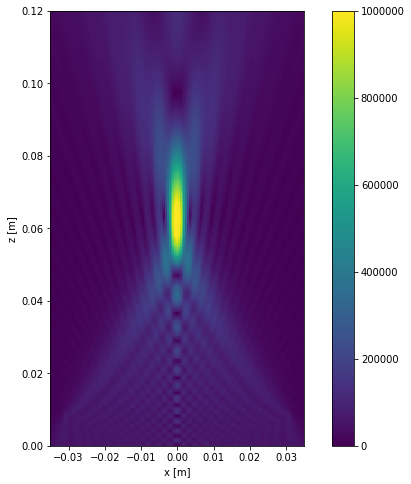

In [10]:
from matplotlib import pylab as plt
%matplotlib inline
incident_pressure = incident_pressure.reshape([Nx, Nz])
fig = plt.figure(figsize=(10, 8))
plt.imshow(np.flipud(np.abs(incident_pressure.T)), extent=[xmin, xmax, zmin, zmax], clim=[0,1e6], cmap='viridis')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.colorbar()
plt.show()

## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. Let us use a model with default settings.

In [11]:
model = optimus.model.create_default_model(source, geometry, material_ext, material_int)

In [12]:
optimus.global_parameters.preconditioning.osrc.damped_wavenumber = 1122.0499961270032+49.899688951596126j

After creating the model, it needs to be solved to obtain the surface potentials at the material interface. Depending on the size of the model, this can be computationally expensive. The solution will be stored inside the model object.

In [13]:
model.solve()

## Visualisation of the acoustic field

The acoustic field can be calculated at arbitrary points. Let us visualize the field on a grid in the plane $z=0$.

In [14]:
optimus.global_parameters.postprocessing.quadrature_order = 20
postprocess_plane = optimus.postprocess.VisualisePlane(model)
postprocess_plane.create_computational_grid(resolution=(141, 241), bounding_box=(-0.035, 0.035, 0.0, 0.12),
                                            plane_axes=(1, 2))
postprocess_plane.compute_fields()

Let us first visualise the incident field in the exterior domain.

The pressure field in the entire domain is as follows.

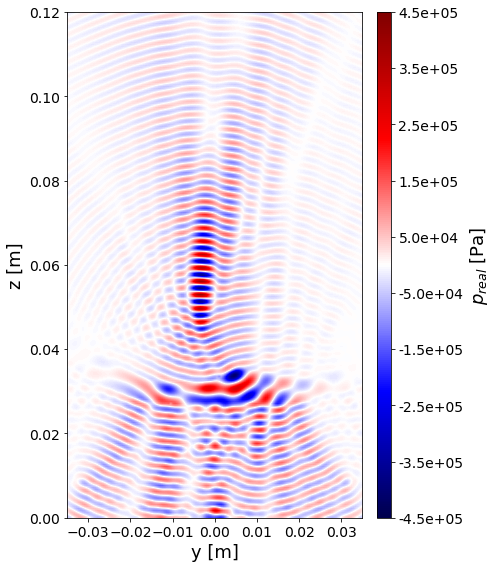

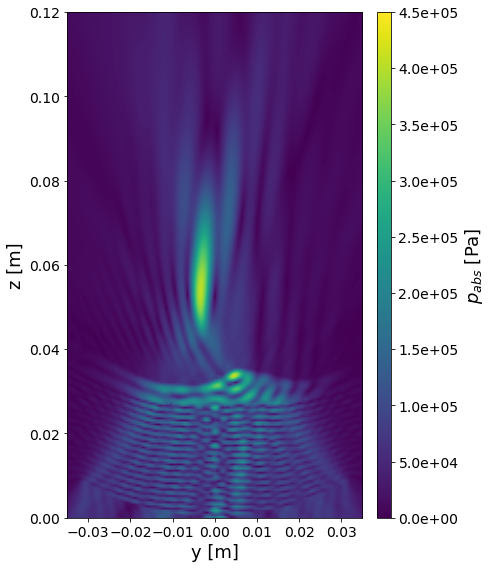

In [17]:
%matplotlib inline
figs = optimus.postprocess.plot_pressure_field(postprocess_plane, field="total", clim=(-0.45e6, 0.45e6), display_edges=False)